In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from simplefwi.misfit import MisfitFunction, DataMisfit, RegMisfit
from simplefwi.optimization import BBiter, CGiter
from simplefwi.core import ForwardSolver
from scipy.sparse import linalg
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat

In [2]:
def slowness_model(n):
    # Model
    vback = 2.0
    vel = vback * np.ones(n)
    rr, cc = disk((n[0] // 2, n[1] // 2), radius=20, shape=vel.shape)
    vel[rr, cc] = 2.25

    m = 1. / (vel.reshape(-1, 1)) ** 2
    m0 = 1. / (vback * np.ones(n).reshape(-1, 1)) ** 2

    return m, m0

In [3]:
f = np.array([5., 10., 15.])
h = np.array([10., 10.]) # z, x
n = np.array([151, 101]) # z, x

z = np.arange(0, n[0]) * h[0]
x = np.arange(0, n[1]) * h[1]

zs = np.arange(h[0], z[-1], 2 * h[0])
xs = 2 * h[1] * np.ones_like(zs)

zr = np.arange(h[0], z[-1], 2 * h[0])
xr = (n[1]-2) * h[1] * np.ones_like(zr)

q = np.eye(len(xs))

In [4]:
model = {
    'h': h,
    'f': f,
    'xr': xr,
    'zr': zr,
    'xs': xs,
    'zs': zs,
    'n': n,
    'z': z,
    'x': x,
    'q': q,
}

In [5]:
m, m0 = slowness_model(n)

Fm = ForwardSolver(model)
Dobs, Jo = Fm.solve(m)
dataMisfit = DataMisfit(Dobs, model)
regMisfit = RegMisfit(n, alpha=0.5, m0=m0)
misfitFn = MisfitFunction(dataMisfit, regMisfit)

/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:122: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_l],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ncp_add_at(y, [self.iava_t, self.iava_r],
/Users/ravasim/Desktop/KAUST/OpenSource/pylops/pylops/signalprocessing/Bilinear.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(se

In [6]:
history, mk, gk = BBiter(misfitFn, m0, tol=1.e-3, maxit=10)
# history, mk, gk = CGiter(misfitFn, m0, Dobs, Fm, tol=1.e-6, maxit=10)

Optimization starts!
k: 1  fk: 7298.06  ||gk||: 18706.93
k: 2  fk: 1686.39  ||gk||: 6542.38
k: 3  fk: 706.07  ||gk||: 3246.26
k: 4  fk: 396.23  ||gk||: 3158.88
k: 5  fk: 719.02  ||gk||: 8605.02
k: 6  fk: 251.89  ||gk||: 3403.50
k: 7  fk: 162.01  ||gk||: 984.18
k: 8  fk: 147.42  ||gk||: 920.50
k: 9  fk: 40.47  ||gk||: 508.04
k: 10  fk: 85.65  ||gk||: 2376.82
Optimization ended!


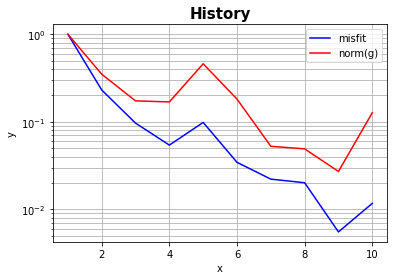

In [7]:
plt.figure()
plt.semilogy(history[:, 0], history[:, 1] / history[0, 1], "b-", label='misfit')
plt.semilogy(history[:, 0], history[:, 2] / history[0, 2], "r-", label='norm(g)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('History', fontsize=15, fontweight='bold')
plt.legend()
plt.grid('on', which='both')
plt.axis('tight')
plt.show()

(-0.5, 100.5, 150.5, -0.5)

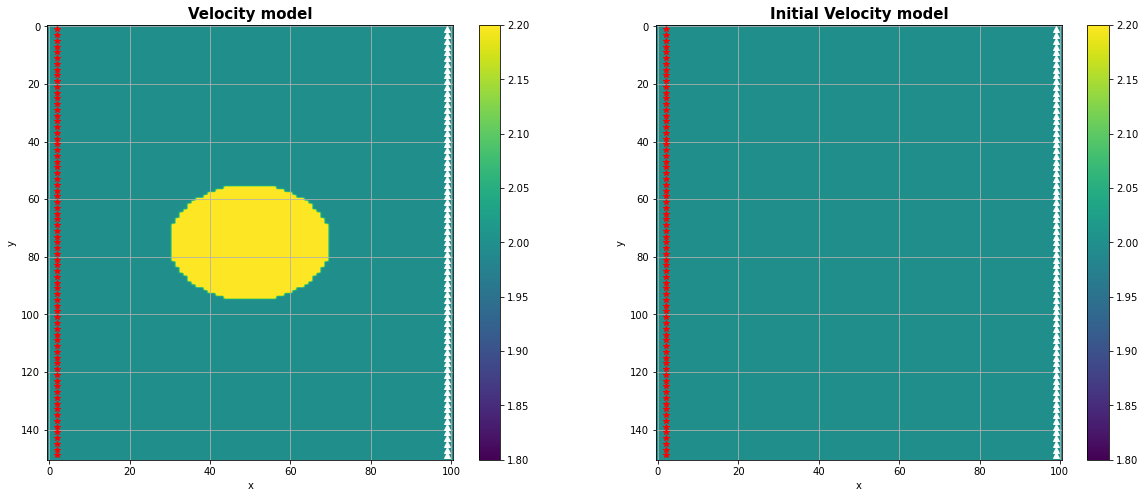

In [8]:
# plot model
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(1./np.sqrt(m).reshape(n), vmin=1.8, vmax=2.2)
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

plt.subplot(122)
plt.imshow(1./np.sqrt(m0).reshape(n), vmin=1.8, vmax=2.2)
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

(-0.5, 100.5, 150.5, -0.5)

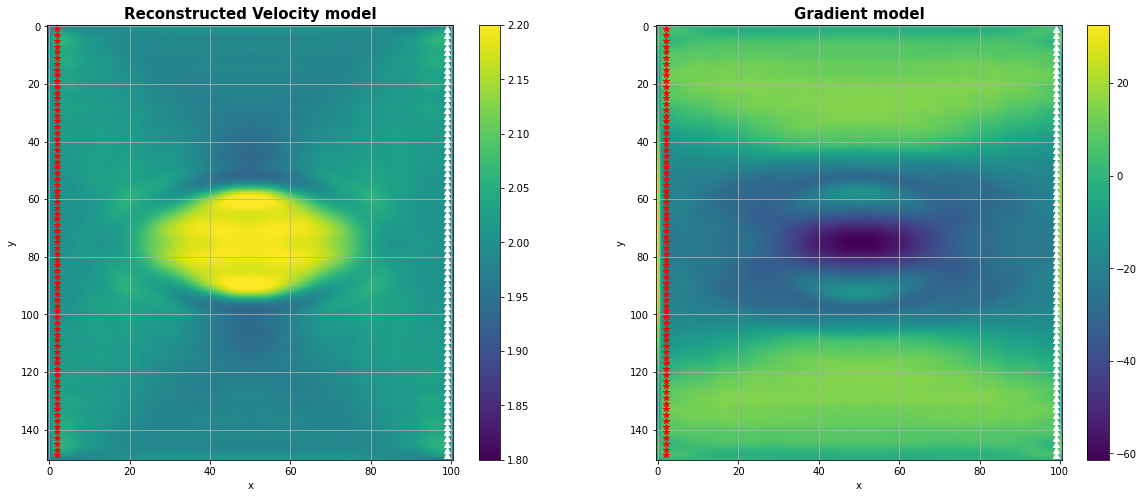

In [9]:
# plot model
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(1./np.sqrt(mk).reshape(n), vmin=1.8, vmax=2.2)
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reconstructed Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')

plt.subplot(122)
plt.imshow(gk.reshape(n))
plt.plot(xr // h[0], zr // h[1], 'w^')
plt.plot(xs // h[0], zs // h[1], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight')